In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import json, os, warnings

# Visualization of postal code-level correlations
In the first notebook, we saw how being located in different clusters can correlate to different success rates for restaurants. Here, we show how we have access to finer-grained information.

Canadian postal codes take the form 1A1 A1A, with the first three characters corresponding to larger regions and the second group of three characters usually specifying a location down to a few blocks. We will use the first three characters to group features geographically. While this is only a crude grouping, it nonetheless allows us to correlate the number of restaurants to three of the many features we have at our disposal.

In [5]:
license_data = {}
tax_data = {}
years = [13,14,15,16,17,18,19]

for year in years:
    with open(f'data/licenses_20{year}.txt', 'r') as infile:
        loaded_text = json.load(infile)
    records = [record['fields'] for record in json.loads(loaded_text)]
    idx = [record['recordid'] for record in json.loads(loaded_text)]
    license_data[year] = pd.DataFrame(records, index=idx)
    license_data[year]['postal3'] = license_data[year]['postalcode'].str[:3]
    license_data[year]['numberofemployees'] = license_data[year]['numberofemployees'].astype('float')
    
    with open(f'data/taxes_20{year}.txt', 'r') as infile:
        loaded_text = json.load(infile)
    records = [record['fields'] for record in json.loads(loaded_text)]
    idx = [record['recordid'] for record in json.loads(loaded_text)]
    tax_data[year] = pd.DataFrame(records, index=idx)
    tax_data[year]['postal3']=tax_data[year]['property_postal_code'].str[:3]

In [8]:
restaurant_counts = pd.Series(license_data[19][license_data[19].businesstype.str.contains('restaurant', case=False)]['postal3'].value_counts(), name='restaurant_count')

retail_mask = license_data[19]['businesstype'].str.contains('Retail', case=False)
retail_counts = pd.Series(license_data[19][retail_mask]['postal3'].value_counts(), name='retail_count')

ages =  tax_data[19][['postal3','year_built']].dropna()
ages['age'] = 2019 - ages['year_built'].astype('float')
ages = ages.groupby('postal3').median()

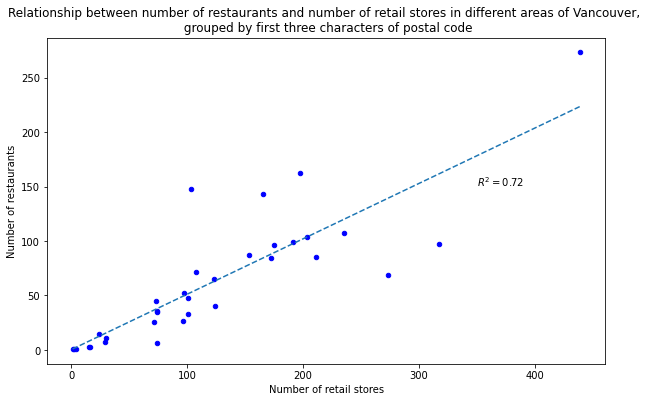

In [40]:
counts_data = pd.merge(restaurant_counts,retail_counts,left_index=True,right_index=True)
counts_data.plot.scatter(x='retail_count', y='restaurant_count',c='blue');
fit_params = np.polyfit(counts_data['retail_count'], counts_data['restaurant_count'],1)
y = np.poly1d(fit_params)(counts_data['retail_count'])

plt.rcParams["figure.figsize"]=(10,6)

plt.plot(np.sort(counts_data['retail_count']), np.sort(y),'--')

plt.xlabel('Number of retail stores')
plt.ylabel('Number of restaurants')


r2=r2_score(counts_data['restaurant_count'],y);
plt.text(350,150,f'$R^2=${round(r2,2)}');
plt.title('Relationship between number of restaurants and number of retail stores in different areas of Vancouver, \n grouped by first three characters of postal code');

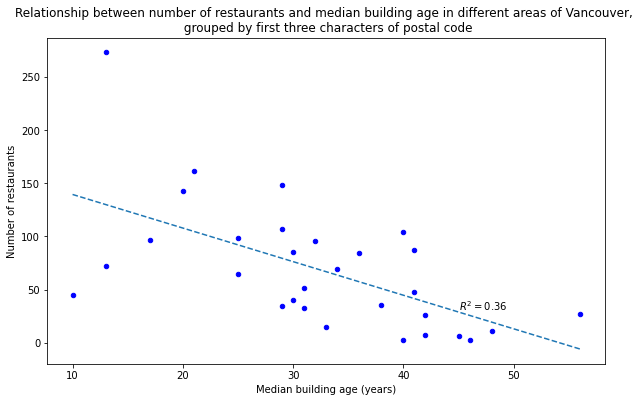

In [108]:
restaurant_age_data = pd.merge(restaurant_counts,ages,left_index=True,right_index=True)
restaurant_age_data.plot.scatter(x='age', y='restaurant_count',c='blue');
plt.ylabel('Number of restaurants')
plt.xlabel('Median building age (years)')
fit_params = np.polyfit(restaurant_age_data['age'], restaurant_age_data['restaurant_count'],1)
y = np.poly1d(fit_params)(restaurant_age_data['age'])
plt.plot(np.sort(restaurant_age_data['age']),-np.sort(-y),'--')
r2=r2_score(restaurant_age_data['restaurant_count'],y)
plt.text(45,30,f'$R^2=${round(r2,2)}');
plt.title('Relationship between number of restaurants and median building age in different areas of Vancouver, \n grouped by first three characters of postal code');

In [52]:
commercial_mask = tax_data[19]['zone_category'].str.contains('Dwelling', case=False) == False

In [101]:
value_data = tax_data[19][commercial_mask][['postal3','current_land_value']].groupby('postal3').sum()/(1e9)

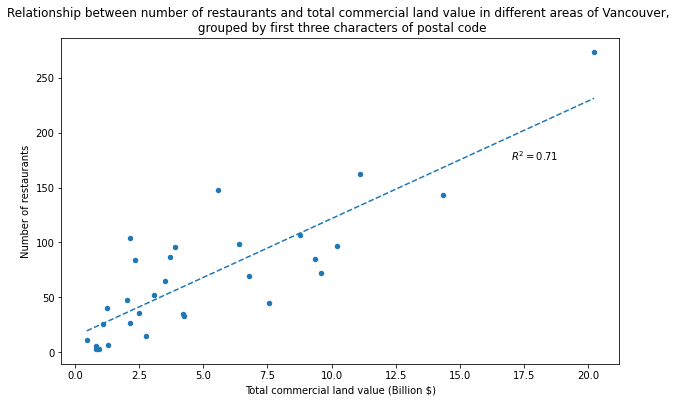

In [111]:
restaurant_value_data = pd.merge(restaurant_counts,value_data,left_index=True,right_index=True)
fit_params = np.polyfit(restaurant_value_data['current_land_value'], restaurant_value_data['restaurant_count'],1)
y = np.poly1d(fit_params)(restaurant_value_data['current_land_value'])

restaurant_value_data.plot.scatter(x='current_land_value',y='restaurant_count')
plt.plot(np.sort(restaurant_value_data['current_land_value']),np.sort(y),'--')
r2=r2_score(restaurant_value_data['restaurant_count'],y)
plt.text(17.,175,f'$R^2=${round(r2,2)}');
plt.title('Relationship between number of restaurants and total commercial land value in different areas of Vancouver, \n grouped by first three characters of postal code');
plt.xlabel('Total commercial land value (Billion $)')
plt.ylabel('Number of restaurants');